In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

def cvtbgr(img):
    return cv.cvtColor(img, cv.COLOR_BGR2RGB)

def imshow(img):
    plt.imshow(img)
    plt.show()

# 透视重映射
将经过透视扭曲的矩形重新映射为正常的矩形. 如图所示:

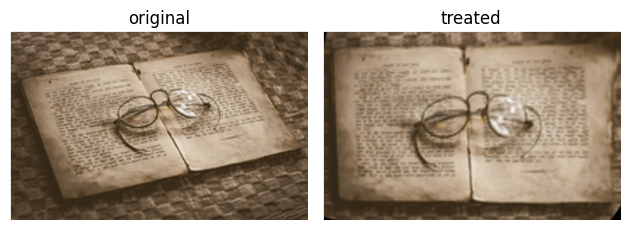

In [2]:
fig, axes = plt.subplots(1, 2)

axes[0].imshow(cvtbgr(cv.imread('figs/pr/tilted_book.png')))
axes[0].axis('off')
axes[0].set_title('original')

axes[1].imshow(cvtbgr(cv.imread('figs/pr/normal_book.png')))
axes[1].axis('off')
axes[1].set_title('treated')

plt.tight_layout()
plt.show()

对于原始图像, 若我们已经知道要处理的矩形的四点 (记为点 $p_i$ , $i=0,1,2,3$):

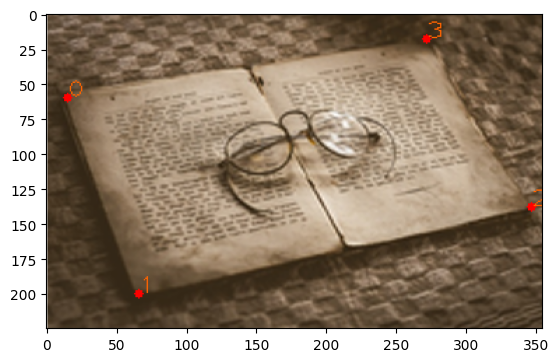

In [3]:
original = cvtbgr(cv.imread('figs/pr/tilted_book.png'))
rect_points = np.array([[ 15,  60],
                        [ 66, 200],
                        [347, 138],
                        [272,  18]])

ori_copy_img = original.copy()
for i, p in enumerate(rect_points):
    cv.circle(ori_copy_img, p, 3, (255,0,0), -1)
    cv.putText(ori_copy_img, str(i), p, cv.FONT_HERSHEY_PLAIN, 1.2, (255,100,0))
imshow(ori_copy_img)

首先我们以 $p_0$ 作为新的坐标原点, 对画面整体平移.
再以向量 $\mathbf{p}_3' := \mathbf{p}_3-\mathbf{p}_0$, $\mathbf{p}_1'$ 作为一组新的基向量,
做坐标系变换.

使用齐次坐标可以很方便地完成平移等操作. 因为我们要找的透视映射不是线性的, 而是一个 **分式线性变换**, 齐次坐标也是后续操作必备的.

构建如下的平移变换矩阵 $T$, 这是个 $3\times3$ 的矩阵, 使用它可以将齐次坐标按指定向量平移.
$$
T = 
\begin{pmatrix}
         I_2 && -\mathbf{p}_0 \\
\mathbf{0}^T && 1
\end{pmatrix}
$$

In [4]:
p0 = rect_points[0]
# 批量转为齐次坐标
rect_homo_points = np.hstack((rect_points, np.ones((rect_points.shape[0], 1))))

T = np.block([[      np.eye(2), np.transpose([-p0])],
              [np.zeros((1,2)),                   1]])

print(f"translation mat `T`:\n{T}\n")
for p in rect_homo_points:
    print(f"map {p} to {T@p}")

translation mat `T`:
[[  1.   0. -15.]
 [  0.   1. -60.]
 [  0.   0.   1.]]

map [15. 60.  1.] to [0. 0. 1.]
map [ 66. 200.   1.] to [ 51. 140.   1.]
map [347. 138.   1.] to [332.  78.   1.]
map [272.  18.   1.] to [257. -42.   1.]


接下来可以做基变换. 为了与上面的平移变换相容, 我们使用 $3\times3$ 的矩阵, 并简单地将多余的对角元设为 $1$.
即:

$$
U^{-1} =
\begin{pmatrix}
\mathbf{p}_3' && \mathbf{p}_1' && \\
              &&               && 1
\end{pmatrix}
$$

In [5]:
p3p = rect_points[3] - p0
p1p = rect_points[1] - p0

U = np.linalg.inv(np.block([[np.transpose([p3p]), np.transpose([p1p]), np.zeros((2,1))],
                            [                  0,                   0,               1]]))

print(f"basis transformation mat `U`:\n{U}\n")
with np.printoptions(precision=2, suppress=True, floatmode='fixed'):
    for p in rect_homo_points@T.T:
        print(f"map {p} to {U@p}")

basis transformation mat `U`:
[[ 0.00367242 -0.00133781  0.        ]
 [ 0.00110173  0.00674151  0.        ]
 [ 0.          0.          1.        ]]

map [0.00 0.00 1.00] to [0.00 0.00 1.00]
map [ 51.00 140.00   1.00] to [-0.00  1.00  1.00]
map [332.00  78.00   1.00] to [1.11 0.89 1.00]
map [257.00 -42.00   1.00] to [1.00 0.00 1.00]


这样一来, 所有自由度都在 $p_2$ 上. 接下来我们只需考虑如何将 $\mathbf{p}'_2$ 映射到 $(1,1)^T$. 不妨记这个映射为 $V$.

下面展示了经过以上变换后的图片 (比例尺 $300:1$, 用红色框出矩形被变换后的区域).

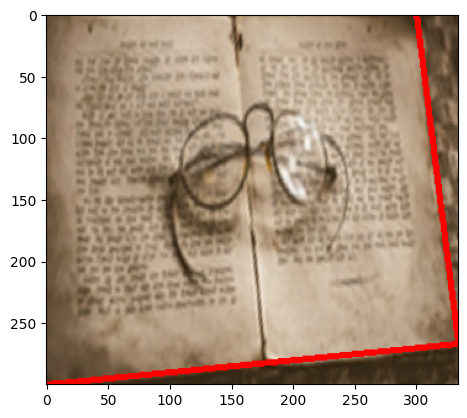

In [6]:
img_scale = 300

# 注意!: 不要将图片经过上述变换之后再进行缩放, 这样做会因为整形转换丢失全部信息.
# 而是应该将上述变换与缩放变换复合为新的变换后, 再统一施与图片. 如下
P = np.diag([img_scale,img_scale,1])@U@T
p2pp = (P@rect_homo_points[2]).astype(int)[:2]
img_size = np.max((p2pp, [img_scale,img_scale]), axis=0)
preprocess_img = cv.warpPerspective(original, P, img_size)

preprocess_tmp_img = preprocess_img.copy()
cv.line(preprocess_tmp_img, (img_scale,0), p2pp, (255,0,0), 3)
cv.line(preprocess_tmp_img, (0,img_scale), p2pp, (255,0,0), 3)

imshow(preprocess_tmp_img)

显然这个映射 $V$ 也不是线性的.

为了弄清楚 $V$ 的矩阵表示,
我们需要先对分式线性变换 (也称 *单应变换* ) 所使用的齐次变换矩阵 (也称 *单应矩阵* ) 进行一些探讨:
$$
\begin{pmatrix}
           A && \mathbf{v} \\
\mathbf{u}^T && \alpha
\end{pmatrix}
$$

矩阵 $A$ 代表一个线性变换, 也就是基向量变换;
$\mathbf{v}$ 代表平移变换, 即将每个点沿 $\mathbf{v}$ 平移.

因为齐次坐标的特殊性, 两个相差某倍数的齐次坐标仍然相等. 在这个意义下, 我们有:
$$
\begin{pmatrix}
           A && \mathbf{v} \\
\mathbf{u}^T && \alpha
\end{pmatrix}
\begin{pmatrix}
\mathbf{p} \\
\beta
\end{pmatrix}

\simeq

\frac{1}{\alpha}
\begin{pmatrix}
           A && \mathbf{v} \\
\mathbf{u}^T && \alpha
\end{pmatrix}
\begin{pmatrix}
\mathbf{p} \\
\beta
\end{pmatrix}
$$
也就是
$$
\begin{pmatrix}
           A && \mathbf{v} \\
\mathbf{u}^T && \alpha
\end{pmatrix}

\simeq

\begin{pmatrix}
\frac{1}{\alpha}A       && \alpha^{-1}\mathbf{v} \\
\alpha^{-1}\mathbf{u}^T && 1
\end{pmatrix}
$$
上面表明了单应矩阵只有 $8$ 个自由度, 虽然它有 $9$ 个变量. 丢失的自由度是因为齐次坐标的缩放不变性.

所以, 剩余的参数 $\mathbf{u}$ 即代表了这个变换. 我们单独分析它.

构建一个包含 $\mathbf{u}$ 最简单的单应矩阵
$
\begin{pmatrix}
I            &&  \\
\mathbf{u}^T && 1
\end{pmatrix}
$
, 显然它可以被拆分为两个方向上的变换:
$$
\begin{pmatrix}
1   &&     &&  \\
    &&   1 &&  \\
u_x && u_y && 1
\end{pmatrix}
=
\begin{pmatrix}
1   &&   &&  \\
    && 1 &&  \\
u_x &&   && 1
\end{pmatrix}
\begin{pmatrix}
1 &&     &&  \\
  &&   1 &&  \\
  && u_y && 1
\end{pmatrix}
$$

那么
$$
V_x :=
\begin{pmatrix}
1   &&   &&  \\
    && 1 &&  \\
u_x &&   && 1
\end{pmatrix}
$$
代表了什么呢?
注意到 $V_x (x, y, 1)^T = (x, y, u_x x + 1)^T \simeq (\frac{x}{u_x x + 1}, \frac{y}{u_x x + 1}, 1)^T$,
且 $V_x (0, 1, 1)^T = (0, 1, 1)^T$, 所以它保持平面上 $(0, 1)$ 位置的点不动, 而把 $y = u_x x + 1$ 这条线映到 $y = 1$ 处,
同时在 $x$ 方向进行了不等比例的缩放.

为了保证 $x$ 的范围仍然在 $[0,1]$ 内, 不妨在 $x$ 方向上进行一次线性缩放:
$$
S_x :=
\begin{pmatrix}
u_x + 1 &&   &&  \\
        && 1 &&  \\
        &&   && 1
\end{pmatrix}
$$

为什么上面 $V_x$ 在 $x$ 方向的缩放是非线性的 (事实上是呈反比例函数), 而这里要进行一次线性的缩放?
这是因为 $V_x$ 模拟的是图片在空间中改变角度后投影在屏幕上, 可以想象图片偏移一个角度后, 呈现近处大而远处小的效果.
不难证明, 这个效果是关于距离的反比例函数, 和上面一致.
但是这里进行的线性缩放, 仅仅是为了保证结果在给定的 $[0,1]$ 范围内, 相当于把图片放得更远 (或近) 一些, 此时图片是成比例变大变小的.

下面展示了这个变换过程. 为了方便观看, 标记上了蓝色条纹. 红色线条即为 $y = u_x x + 1$. 比例尺 $100:1$.

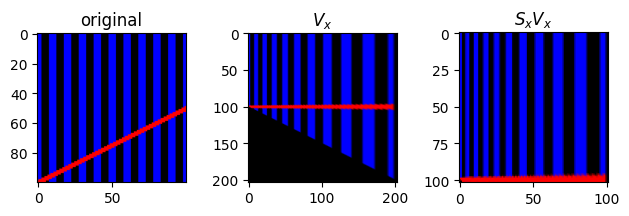

In [ ]:
u_x = -0.5
img_scale = 100

tmp_img = np.zeros((img_scale, img_scale, 3), dtype=np.uint8)
for x in np.linspace(0, img_scale, 11):
    cv.line(tmp_img, (int(x),0), (int(x), 99), (0,0,255), 3)
cv.line(tmp_img, (0,img_scale), (img_scale,int(u_x*img_scale+img_scale)), (255,0,0), 2)

V_x = np.array([[  1, 0, 0],
                [  0, 1, 0],
                [u_x, 0, 1]])
s = np.diag([img_scale,img_scale,1])
output_size = int(img_scale/(u_x+1))
output_tmp_img = cv.warpPerspective(tmp_img, s@V_x@np.linalg.inv(s), (output_size+3,output_size+3))

S_x = np.array([[u_x + 1, 0, 0],
                [      0, 1, 0],
                [      0, 0, 1]])
scale_output_tmp_img = cv.warpPerspective(output_tmp_img, S_x, (img_scale+1,img_scale+2))

fig, axes = plt.subplots(1, 3)
axes[0].imshow(tmp_img)
axes[0].set_title('original')
axes[1].imshow(output_tmp_img)
axes[1].set_title('$V_x$')
axes[2].imshow(scale_output_tmp_img)
axes[2].set_title('$S_x V_x$')
plt.tight_layout()
plt.show()

同样地,
$$
V_y :=
\begin{pmatrix}
1 &&     &&  \\
  &&   1 &&  \\
  && u_y && 1
\end{pmatrix}
$$
$$
S_y :=
\begin{pmatrix}
1 &&         &&  \\
  && u_y + 1 &&  \\
  &&         && 1
\end{pmatrix}
$$
也可以被这样推导出来.

所以我们要找的映射 $V$ 就是 $V_y' V_x' = (S_y V_y) (S_x V_x)$ 吗?
要回答这个问题, 需要想清楚 **在 $x$ 方向的变换会不会影响后续在 $y$ 方向的变换**.
事实上这两个变换的确不会互相影响. 要理解它, 只需考虑这样一件事:
假如在 $V_y' V_x'$ 作用后, 消除 $V_x'$ 的影响, 即 $V_x'^{-1} V_y' V_x'$, 它是否和 $V_y'$ 的作用一致. 也就是说如果
$$
V_x'^{-1} V_y' V_x' = V_y' \Leftrightarrow V_y' V_x' = V_x' V_y'
$$
那么两个矩阵就不会互相影响.

显然 $V_x'$ 与 $V_y'$ 是可交换的, 因此
$$
\begin{align*}
V & = S_y V_y S_x V_x \\
  & =
\begin{pmatrix}
u_x + 1 &&         &&  \\
        && u_y + 1 &&  \\
    u_x &&     u_y && 1
\end{pmatrix}
\end{align*}
$$

最后, 我们指出如何求出 $\mathbf{u} = (u_x, u_y)^T$.
注意到 $V \widetilde{\mathbf{p}}'_2 = (1, 1, 1)^T$, 可以据此直接求出 $\mathbf{u}$.

令 $\widetilde{\mathbf{p}}'_2 = (\lambda, \mu, 1)^T$, 直接给出
$$
\mathbf{u} =
\frac{1}{1-\lambda-\mu}
\begin{pmatrix}
    \mu - 1 \\
\lambda - 1
\end{pmatrix}
$$

perspective transformation mat `V`:
[[ 0.88584832  0.          0.        ]
 [ 0.          1.1076883   0.        ]
 [-0.11415168  0.1076883   1.        ]]

map [1.11 0.89 1.00] to [0.99 0.99 0.97]


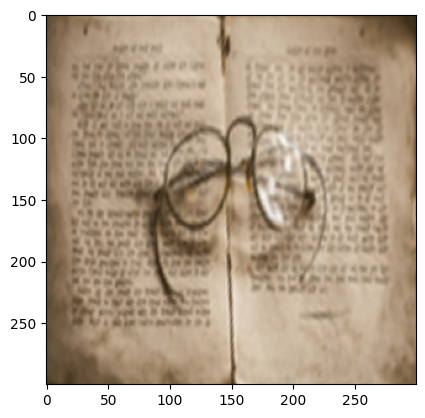

In [8]:
img_scale = 300

p2pt = U@T@rect_homo_points[2]
u_x, u_y = 1./(1.-p2pt[0]-p2pt[1]) * (p2pt[:2] - np.ones(2))

V = np.array([[u_x + 1,       0, 0],
              [      0, u_y + 1, 0],
              [    u_x,     u_y, 1]])

print(f"perspective transformation mat `V`:\n{V}\n")
with np.printoptions(precision=2, suppress=True, floatmode='fixed'):
    print(f"map {p2pt} to {V@p2pt}")

s = np.diag([img_scale,img_scale,1])
imshow(cv.warpPerspective(preprocess_img, s@V@np.linalg.inv(s), (img_scale,img_scale)))

可以看到非常完美的完成了透视重映射工作.

最后我们给出上面图像计算得出的单应矩阵 (经过归一化处理), 调用 OpenCV 的 API 计算得出的结果,
以及用 OpenCV 矩阵进行透视重映射后的图像.

可以看到矩阵间的误差很小, 且图像几乎一模一样.

homograhpy transformation mat `H=VUT`:
[[ 3.41799983e-03 -1.24512851e-03  2.34377131e-02]
 [ 1.28218737e-03  7.84576556e-03 -4.89978744e-01]
 [-3.15795430e-04  9.23206165e-04  1.00000000e+00]]

homograhpy transformation mat solved by opencv:
[[ 3.51467704e-03 -1.28034664e-03  2.41006426e-02]
 [ 1.31845369e-03  8.06768094e-03 -5.03837662e-01]
 [-2.27985884e-04  1.05881769e-03  1.00000000e+00]]



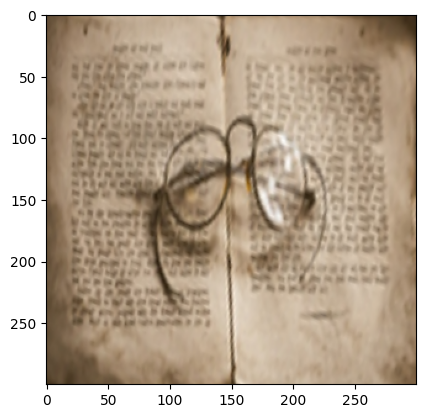

In [9]:
H = V@U@T
H *= 1./H[-1, -1]
print(f"homograhpy transformation mat `H=VUT`:\n{H}\n")

dst = np.array([[0, 0],
                [0, 1],
                [1, 1],
                [1, 0]], dtype=np.float32)
HH = cv.getPerspectiveTransform(rect_points.astype(np.float32), dst)
print(f"homograhpy transformation mat solved by opencv:\n{HH}\n")

imshow(cv.warpPerspective(original, s@H, (img_scale,img_scale)))